In [2]:
# Packages for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Packages for PostgreSQL Import
import psycopg2

# Custom packages with database connection information (Not working)
    #from projectname.config import dbname, username, pswd

In [3]:
# Ideally I'll move this into the project config.py file
# Otherwise for now I have to just manually assign . . .

dbname = "freelance_db"
username = "Metaverse"
pswd = "Arcifice91"

In [15]:
# Connect to Data (from: scraping_data.ipynb)

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Column reference
sql_query = """SELECT * FROM INFORMATION_SCHEMA.TABLES;"""
col_ref = pd.read_sql_query(sql_query,con)
col_ref[col_ref['table_schema'] == "public"]['table_name']

0          freelance_db
1    user_details_table
4         details_table
Name: table_name, dtype: object

In [17]:
# Checking shapes of tables
sql_query = """SELECT * from user_details_table;"""
dtls_table = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * from freelance_db;"""
fl_table = pd.read_sql_query(sql_query, con)

print(user_details_table.shape)
print(fl_table.shape)

(200, 8)
(3406, 8)


### EDA for 'fl_table'

1. Remove 4 obs of someone from Punjab

In [19]:
print(fl_table.shape)
fl_table.head()

(3406, 8)


,index,profile_url,city,state,country,hourly_rate,skills_list,user_description
0,0,https://www.guru.com/freelancers/dugale,Long Beach,California,United States,5,Adobe InDesign,WordPress (Theme and Plugin Development) PHP/P...
1,1,https://www.guru.com/freelancers/dugale,Long Beach,California,United States,5,Adobe Photoshop,WordPress (Theme and Plugin Development) PHP/P...
2,2,https://www.guru.com/freelancers/dugale,Long Beach,California,United States,5,Ajax,WordPress (Theme and Plugin Development) PHP/P...
3,3,https://www.guru.com/freelancers/dugale,Long Beach,California,United States,5,CSS,WordPress (Theme and Plugin Development) PHP/P...
4,4,https://www.guru.com/freelancers/dugale,Long Beach,California,United States,5,CSS3,WordPress (Theme and Plugin Development) PHP/P...


In [22]:
# Basic descriptives: Outcome - hourly_rate
fl_table['hourly_rate'].mean()

43.46594245449207

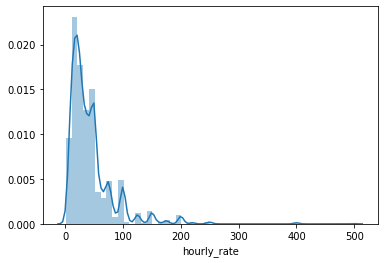

In [24]:
# Distribution
sns.distplot(fl_table['hourly_rate'])

In [29]:
# Number of different cities?
fl_table['city'].nunique()

118

In [32]:
# All in same state?
print(fl_table['state'].nunique())

print(fl_table['state'].drop_duplicates())

2
0       California
2083        Punjab
Name: state, dtype: object


In [37]:
# Just one person from punjab
print(fl_table[fl_table['state'] == "Punjab"].count())
fl_table[fl_table['state'] == "Punjab"]

index               4
profile_url         4
city                4
state               4
country             4
hourly_rate         4
skills_list         4
user_description    4
dtype: int64


,index,profile_url,city,state,country,hourly_rate,skills_list,user_description
2083,0,https://www.guru.com/freelancers/irshad-ali-1,Pattoki kasur,Punjab,Pakistan,15,Article Submission,i have a lot of experience in every type of Da...
2400,1,https://www.guru.com/freelancers/irshad-ali-1,Pattoki kasur,Punjab,Pakistan,15,Cpas & Public Accountants,i have a lot of experience in every type of Da...
2423,2,https://www.guru.com/freelancers/irshad-ali-1,Pattoki kasur,Punjab,Pakistan,15,Data Entry,i have a lot of experience in every type of Da...
2849,3,https://www.guru.com/freelancers/irshad-ali-1,Pattoki kasur,Punjab,Pakistan,15,Link Building,i have a lot of experience in every type of Da...


In [41]:
# Removing seller from Punjab
fl_table = fl_table[fl_table['state'] != "Punjab"]
print(fl_table.shape)

(3402, 8)


In [ ]:
# Can do much much much more from here:
    # 1. Different cities
        # - rate distribution by city?
        # - Number of unique obs by city?
        # - Create a map?
    # 2. Inspect skills
        # - Number of different skills?
        # - Which skills are the most common? How does rate vary within those?
        # - Group skills (???) and calculate hourly rate 
        #   distribution by those groupings
    # 3. Inspect description
        # - Text analysis of some kind.
        # - Also will need to go back and scrape info from the user pages.
        #   Could also try Selenium but may be faster to just scrape on static page.
        #   Nvm. Will have to use Selenium.